# PCA
In this notebook, we are going to run a PCA on the variants! yassss
Most of this code is from my final in cs237 (pca prototyping baby)

In [18]:
import allel
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle as pkl
import json
import umap

# for the maps
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

### 1: Process for PCA

First, we need to load ouru vcf and preprocess. 

In [19]:
#  file paths
vcf_path = 'data/variants.vcf.gz'
metadata = pd.read_csv("data/fixed.csv")

Epic. Now, we can use the allel package to process into the callset into a genotype matrix.

In [20]:
# this reads the vcf file into a callset
callset = allel.read_vcf(vcf_path)

# this makes the genotype allele!
gt = allel.GenotypeArray(callset['calldata/GT'])
variants = pd.DataFrame({
    'CHROM': callset['variants/CHROM'],
    'POS': callset['variants/POS'],
    'ID': callset['variants/ID'],
    'REF': callset['variants/REF'],
    'ALT': [a[0] if isinstance(a, (list, tuple)) and len(a) > 0 else None for a in callset['variants/ALT']]
})

# this gives us our list of samples.
samples = list(callset['samples'])

/Users/skylarwalters/miniconda3/envs/cs2370/lib/python3.13/site-packages/allel/io/vcf_read.py:1732: UserWarning:

invalid INFO header: '##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)",Version="3">\n'



This takes a while to run. We can save the genotype matrix to file to make it less tedious. 

In [21]:
# save so we dont have to keep running...
variants.to_csv(f'data/variants.csv', index=False) 
np.save(f'data/genotype_matrix.npy', gt)

### 2: Run PCA
Transpose genotype matrix to process for PCA

In [22]:
geno = gt.to_n_alt()
print(f'Genotype matrix: {geno.shape}')
transposed = geno.T
print(f'Transposed matrix: {transposed.shape}')

Genotype matrix: (551, 23)
Transposed matrix: (23, 551)


In [23]:
# set pcs
pcs=15
pca = PCA(n_components=pcs)
X_pca = pca.fit_transform(transposed)
print("PCA finished.")
print(f"Explained Vriance Ratio: {pca.explained_variance_ratio_}")

PCA finished.
Explained Vriance Ratio: [0.18324576 0.13898415 0.08662126 0.08305578 0.06828666 0.06051253
 0.04879288 0.04350676 0.04004717 0.03905921 0.02918595 0.02729523
 0.02485807 0.02352044 0.02121247]


In [24]:
# get subset from metadata
sample_to_loc = {sam: (loc, age) for loc, age, sam in zip(metadata['Location'], metadata['Age'], metadata['Sample_Name'])}
locations = metadata["Location"]
ages = metadata["Age"]
centuries = metadata["Century"]
samples = metadata["Sample_Name"]

### Plot the PCA

In [25]:

unique_locations = sorted(set(locations))
unique_ages = sorted(set(centuries))
        
colors_dict_loc = {pop: plt.cm.tab20(i) for i, pop in enumerate(unique_locations)}
colors_dict_age = {pop: plt.cm.tab20(i) for i, pop in enumerate(unique_ages)}

colors_loc = [colors_dict_loc[loc] for loc in locations]
colors_time = [colors_dict_age[age] for age in centuries]

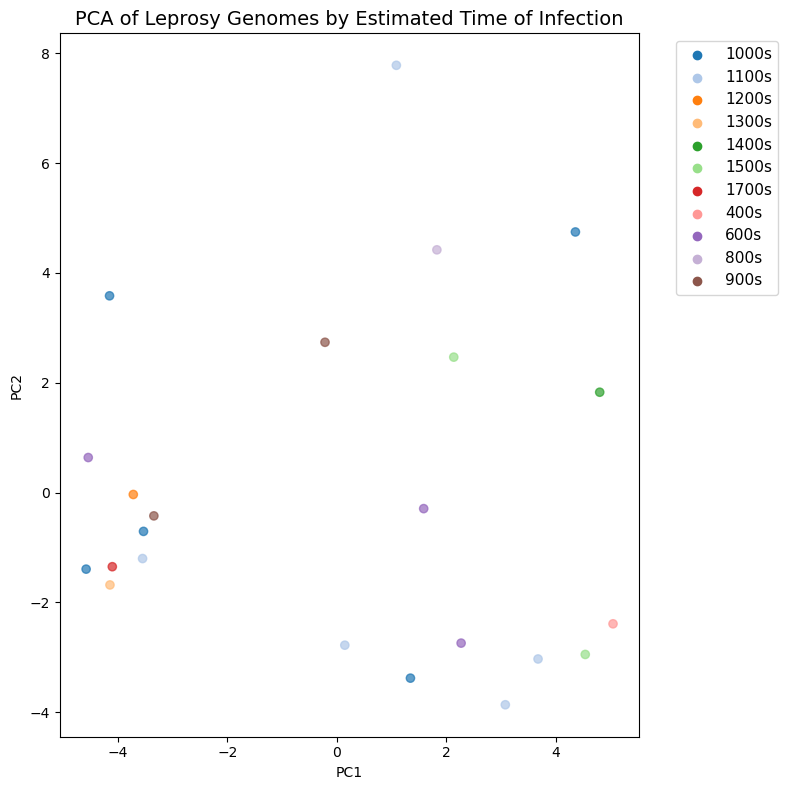

In [26]:
plt.figure(figsize=(8,8))

plt.scatter(X_pca[:,0], X_pca[:,1], 
            c=colors_time, 
            alpha=0.7,
            )
for century in unique_ages:
    plt.scatter([], [], 
                color=colors_dict_age[century], 
                label=century
                )
    
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Leprosy Genomes by Estimated Time of Infection", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), 
           loc='upper left', 
           fontsize=11)
plt.tight_layout()

plt.savefig('fig/pca_by_year.png')
plt.show()

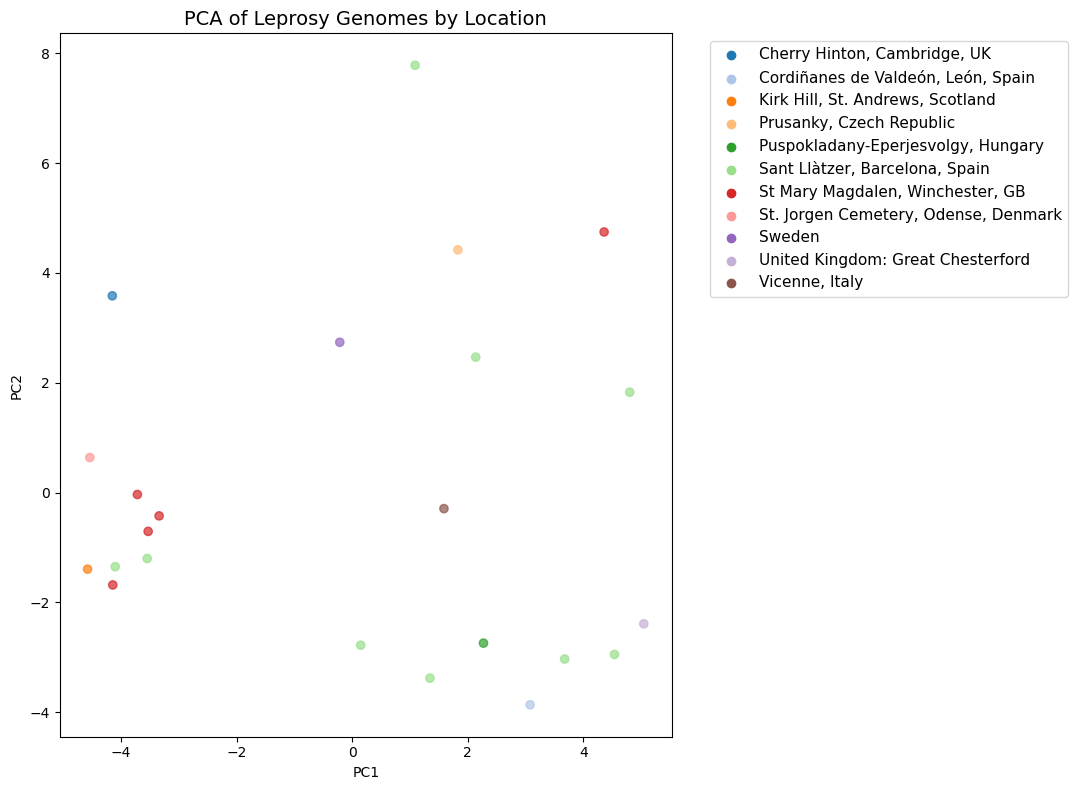

In [27]:
plt.figure(figsize=(11,8))

plt.scatter(X_pca[:,0], X_pca[:,1], 
            c=colors_loc, 
            alpha=0.7,
            )
for loc in unique_locations:
    plt.scatter([], [], 
                color=colors_dict_loc[loc], 
                label=loc
                )
    
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Leprosy Genomes by Location", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), 
           loc='upper left', 
           fontsize=11)
plt.tight_layout()

plt.savefig('fig/pca_by_location.png')
plt.show()

## Plot some additional distance metrics
First, we need to make our genotype matrix into a distance matrix.

genotype mat: (551, 23) --> num snps x num samples

Dist mat: (23, 23) --> num samples x num samples

In [28]:
# get the index and change to float
print(transposed.shape)
geno_df = pd.DataFrame(transposed)
print(samples)
geno_df.rows = samples

(23, 551)
0        KirkHill_lep_udg
1     CHRY023_ML9_lep_udg
2           UF803_lep_udg
3           UF800_lep_udg
4            UF25_lep_udg
5            UF21_lep_udg
6            UF11_lep_udg
7             UF8_lep_udg
8       COR_XVIII_lep_udg
9           UF800_lep_udg
10          UF703_lep_udg
11          UF700_lep_udg
12              MMW_H50_1
13              MMW_H80_1
14               Body 188
15                   SK11
16                    T18
17                   GC96
18                    SK2
19                   3077
20             Jorgen_625
21                   SK14
22                    SK8
Name: Sample_Name, dtype: object


/var/folders/g2/5glzdcws7bbg271xmljmgdqh0000gn/T/ipykernel_25679/290691885.py:5: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



In [29]:
n = geno_df.shape[0]
dist = np.zeros((n, n))

G = geno_df.values.astype(float)
n = G.shape[0]

dist = np.zeros((n, n))

for i in range(n):
    for j in range(i+1, n):
        mask = ~np.isnan(G[i]) & ~np.isnan(G[j])
        d = np.sum(G[i,mask] != G[j,mask])
        dist[i,j] = dist[j,i] = d

dist_df = pd.DataFrame(dist, index=samples, columns=samples)

dist_df

Sample_Name,KirkHill_lep_udg,CHRY023_ML9_lep_udg,UF803_lep_udg,UF800_lep_udg,UF25_lep_udg,UF21_lep_udg,UF11_lep_udg,UF8_lep_udg,COR_XVIII_lep_udg,UF800_lep_udg,...,MMW_H80_1,Body 188,SK11,T18,GC96,SK2,3077,Jorgen_625,SK14,SK8
Sample_Name,,,,,,,,,,,,,,,,,,,,,
KirkHill_lep_udg,0.0,91.0,110.0,78.0,169.0,173.0,9.0,141.0,100.0,63.0,...,34.0,153.0,95.0,108.0,140.0,44.0,121.0,36.0,42.0,184.0
CHRY023_ML9_lep_udg,91.0,0.0,185.0,159.0,210.0,204.0,100.0,206.0,189.0,148.0,...,103.0,168.0,176.0,167.0,199.0,103.0,154.0,101.0,121.0,193.0
UF803_lep_udg,110.0,185.0,0.0,78.0,143.0,177.0,109.0,109.0,54.0,77.0,...,122.0,171.0,83.0,118.0,100.0,136.0,151.0,142.0,132.0,166.0
UF800_lep_udg,78.0,159.0,78.0,0.0,161.0,179.0,79.0,109.0,62.0,73.0,...,92.0,161.0,79.0,108.0,96.0,106.0,157.0,112.0,108.0,170.0
UF25_lep_udg,169.0,210.0,143.0,161.0,0.0,224.0,168.0,154.0,153.0,150.0,...,169.0,172.0,156.0,167.0,157.0,185.0,198.0,187.0,173.0,179.0
UF21_lep_udg,173.0,204.0,177.0,179.0,224.0,0.0,172.0,204.0,189.0,174.0,...,181.0,218.0,184.0,201.0,197.0,189.0,206.0,183.0,201.0,203.0
UF11_lep_udg,9.0,100.0,109.0,79.0,168.0,172.0,0.0,134.0,97.0,64.0,...,43.0,154.0,98.0,115.0,135.0,49.0,118.0,43.0,47.0,177.0
UF8_lep_udg,141.0,206.0,109.0,109.0,154.0,204.0,134.0,0.0,103.0,124.0,...,147.0,212.0,118.0,153.0,87.0,153.0,170.0,171.0,155.0,181.0
COR_XVIII_lep_udg,100.0,189.0,54.0,62.0,153.0,189.0,97.0,103.0,0.0,67.0,...,112.0,175.0,89.0,110.0,88.0,128.0,153.0,134.0,116.0,170.0


/Users/skylarwalters/miniconda3/envs/cs2370/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/Users/skylarwalters/miniconda3/envs/cs2370/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



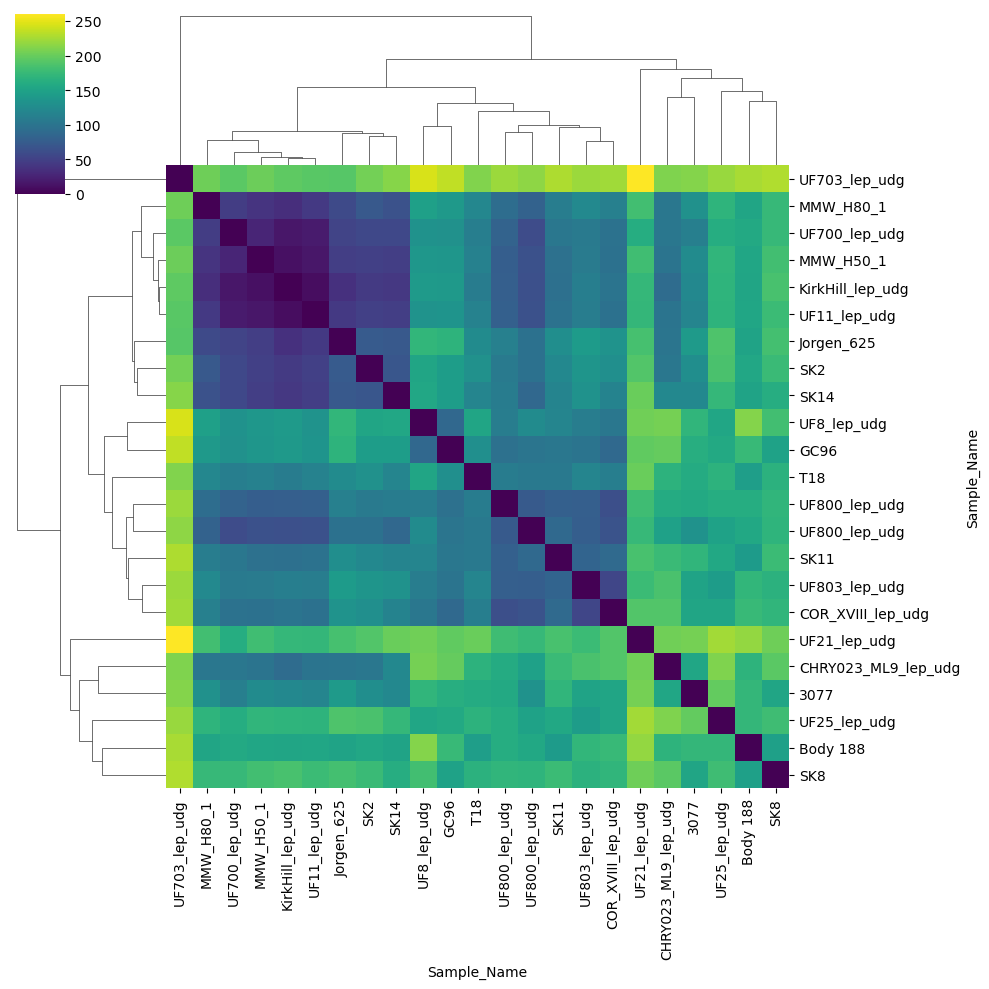

In [30]:
import seaborn as sns
plot = sns.clustermap(dist_df, cmap="viridis", metric="euclidean")
plot.savefig("clustermap_by_sample.png")

Cool. That's the pca baby.

## Let's make some maps.

In [31]:
df = pd.read_csv('data/metadata.csv')
df.head()
sizes=[int(size) for size in df['sz']]

df['text'] = df['Location'] + '<br>Age: ' + df['Age-unformatted']

sz_to_color = {
    3:"darkslateblue",
    5:"indianred",
    9:"darkseagreen"
}

color_seq= [sz_to_color[sz] for sz in sizes]

cities = []
scale = 1

fig = go.Figure()


fig.add_trace(
    go.Scattergeo(
        lon = df['Longitude'],
        lat = df['Latitude'],
        text = df['text'],
        marker = dict(
            size = df['sz'] * 8,
            opacity=0.5,
            color=color_seq,
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),)
    )

legend_sizes = [(3, 'darkslateblue'), (5, 'indianred'), (9, 'darkseagreen')]
for s, c in legend_sizes:
    fig.add_trace(
        go.Scattergeo(
            lon=[None], 
            lat=[None],
            mode="markers",
            marker=dict(
                size=s * 20,
                sizemode="area",
                color=c,
                line=dict(width=0.5, color='black'),
            ),
            name=f"{s} samples"
        )
    )


In [32]:
fig.update_layout(
        title_text = 'Leprosy Sample Data',
        showlegend = True,
        width=1400,
        height=1400,
        geo = dict(
            scope = 'europe',
            landcolor = 'gainsboro',
        )
    )
fig.write_image("leprosy_map.png")
fig.show()

In [36]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

df = pd.read_csv('data/fixed.csv')
df.head()
sizes=[int(size) for size in df['sz']]
print(sizes)
df['text'] = df['Location'] + '<br>Age: ' + df['Age-unformatted']

colors = ["royalblue","crimson","lightseagreen"]
limits = [(0,1),(1,9),(9,20)]
cities = []
scale = 1

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(
        lon = df_sub['Longitude'],
        lat = df_sub['Latitude'],
        text = df_sub['text'],
        marker = dict(
            size = 10,
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
        title_text = '2014 US city populations<br>(Click legend to toggle traces)',
        showlegend = True,
        height=1000,
        width=1000,
        geo = dict(
            scope = 'europe',
            landcolor = 'rgb(217, 217, 217)',
        )
    )
fig.write_image('map.png')
fig.show()

[3, 3, 9, 9, 9, 9, 9, 9, 3, 9, 9, 9, 5, 5, 3, 3, 3, 3, 5, 3, 3, 5, 5]


In [34]:
import plotly.express as px
df = px.data.gapminder()

fig = px.scatter_geo(df, 
                     scope = 'europe',
                     locations="iso_alpha", color="continent",
                     hover_name="country", size="pop",
                     projection="natural earth")
fig.show()